In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Load the dataset
data = pd.read_csv('owid-covid-data.csv')


data['date'] = pd.to_datetime(data['date'])
data = data[data['date'].dt.year == 2022]
data.fillna(method='ffill', inplace=True)

data['change_new_cases_smoothed'] = data['new_cases_smoothed_per_million'].diff()
data['change_new_deaths_smoothed'] = data['new_deaths_smoothed_per_million'].diff()

data = data[['people_fully_vaccinated_per_hundred', 'population_density', 'total_boosters_per_hundred', 'change_new_cases_smoothed', 'change_new_deaths_smoothed']]
data.dropna(inplace=True)

print(data.describe())

       people_fully_vaccinated_per_hundred  population_density  \
count                         92320.000000        92320.000000   
mean                             53.161170          411.637343   
std                              25.827217         1888.961172   
min                               0.050000            0.137000   
25%                              31.960000           42.729000   
50%                              57.660000           99.110000   
75%                              73.652500          237.016000   
max                             126.890000        20546.766000   

       total_boosters_per_hundred  change_new_cases_smoothed  \
count                92320.000000               92320.000000   
mean                    31.706130                   0.000024   
std                     26.717304                 337.786777   
min                      0.000000              -32696.004000   
25%                      6.430000                   0.000000   
50%                  

C:\Users\krishna\AppData\Local\Temp\ipykernel_5148\3761906128.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


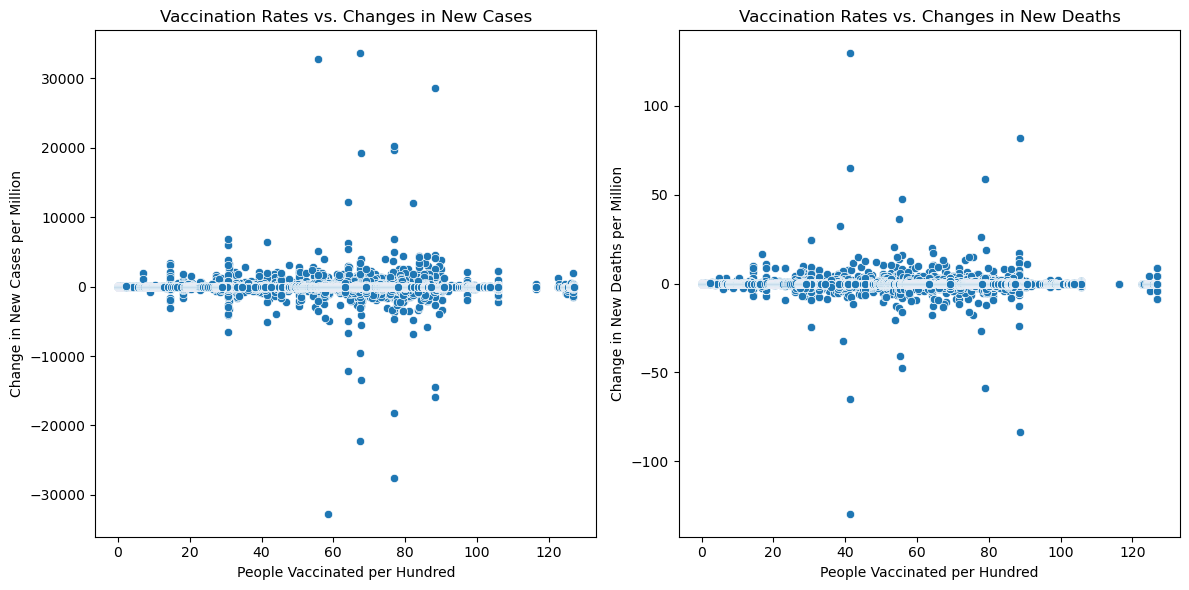

In [3]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='people_fully_vaccinated_per_hundred', y='change_new_cases_smoothed', data=data)
plt.title('Vaccination Rates vs. Changes in New Cases')
plt.xlabel('People Vaccinated per Hundred')
plt.ylabel('Change in New Cases per Million')

plt.subplot(1, 2, 2)
sns.scatterplot(x='people_fully_vaccinated_per_hundred', y='change_new_deaths_smoothed', data=data)
plt.title('Vaccination Rates vs. Changes in New Deaths')
plt.xlabel('People Vaccinated per Hundred')
plt.ylabel('Change in New Deaths per Million')

plt.tight_layout()
plt.show()

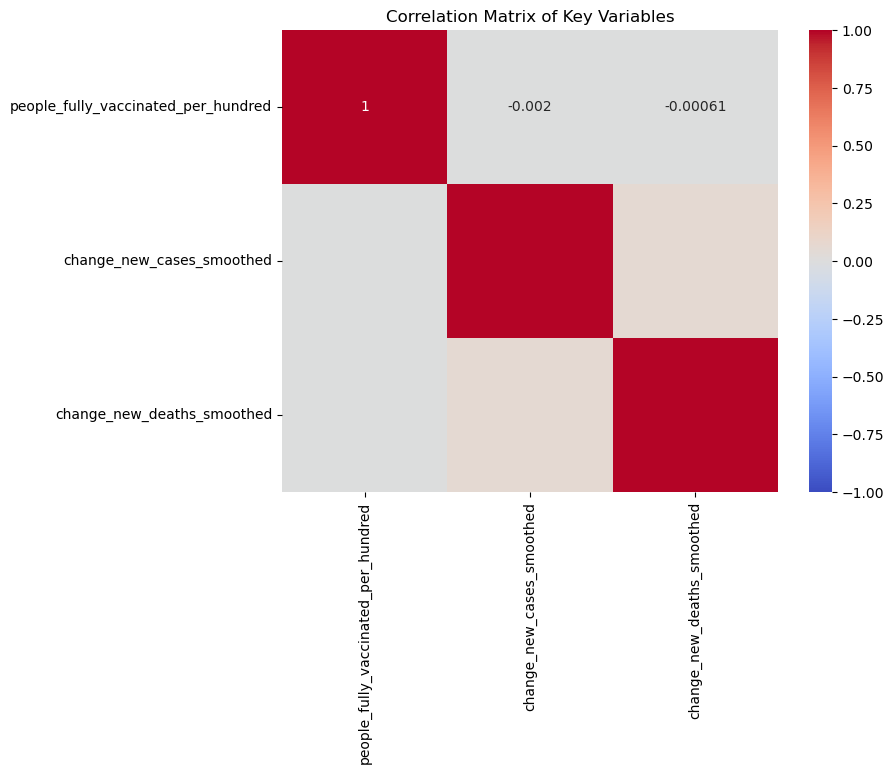

In [4]:
# Correlation matrix to understand the relationships between key variables
corr_matrix = data[['people_fully_vaccinated_per_hundred', 'change_new_cases_smoothed', 'change_new_deaths_smoothed']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Key Variables')
plt.show()

In [5]:
X = data[['people_fully_vaccinated_per_hundred', 'population_density', 'total_boosters_per_hundred']]
y_cases = data['change_new_cases_smoothed']
y_deaths = data['change_new_deaths_smoothed']

# Split the data into training and testing sets
X_train_cases, X_test_cases, y_train_cases, y_test_cases = train_test_split(X, y_cases, test_size=0.2, random_state=42)
X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths = train_test_split(X, y_deaths, test_size=0.2, random_state=42)

In [6]:
# Initialize and train the models
model_cases = LinearRegression()
model_deaths = LinearRegression()

model_cases.fit(X_train_cases, y_train_cases)
model_deaths.fit(X_train_deaths, y_train_deaths)

# Make predictions
y_pred_cases = model_cases.predict(X_test_cases)
y_pred_deaths = model_deaths.predict(X_test_deaths)

In [7]:
# Calculate and print the Mean Squared Error
mse_cases = mean_squared_error(y_test_cases, y_pred_cases)
mse_deaths = mean_squared_error(y_test_deaths, y_pred_deaths)
print(f'Mean Squared Error for Cases: {mse_cases}')
print(f'Mean Squared Error for Deaths: {mse_deaths}')

# Cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Cross-validation for cases
cv_scores_cases = cross_val_score(model_cases, X, y_cases, cv=kf, scoring='neg_mean_squared_error')
cv_mse_cases = -np.mean(cv_scores_cases)
print(f'Cross-Validated Mean Squared Error for Cases: {cv_mse_cases}')

# Cross-validation for deaths
cv_scores_deaths = cross_val_score(model_deaths, X, y_deaths, cv=kf, scoring='neg_mean_squared_error')
cv_mse_deaths = -np.mean(cv_scores_deaths)
print(f'Cross-Validated Mean Squared Error for Deaths: {cv_mse_deaths}')

Mean Squared Error for Cases: 69520.01566707826
Mean Squared Error for Deaths: 0.441276143348274
Cross-Validated Mean Squared Error for Cases: 114102.34830143666
Cross-Validated Mean Squared Error for Deaths: 1.0878689162659867


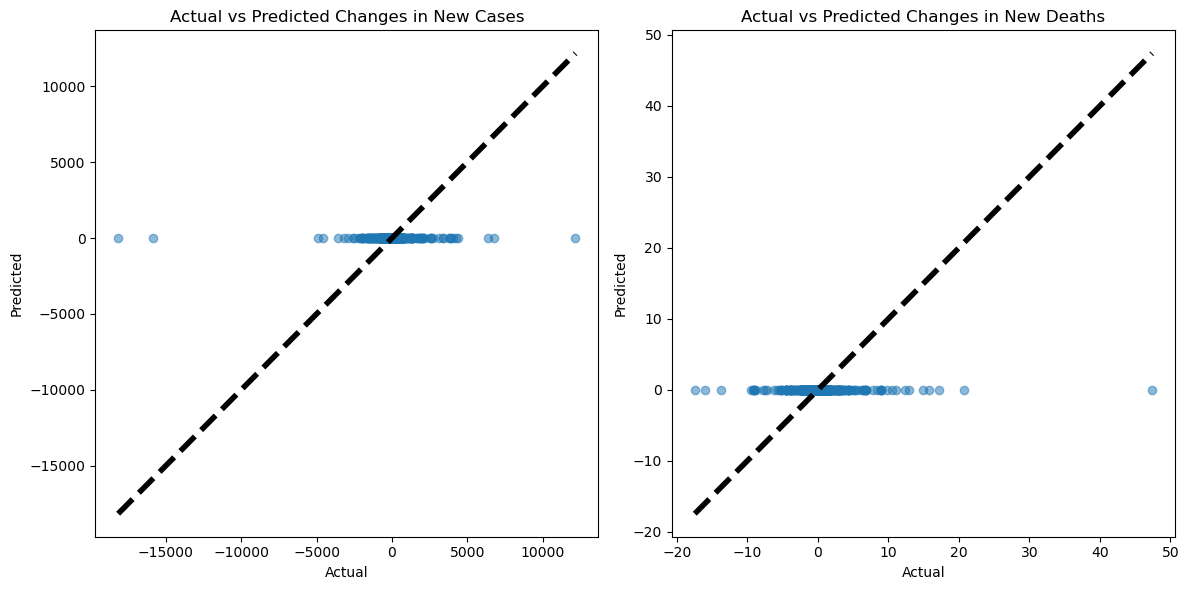

In [8]:
# Visualizations
plt.figure(figsize=(12, 6))

# Plotting actual vs predicted for new cases
plt.subplot(1, 2, 1)
plt.scatter(y_test_cases, y_pred_cases, alpha=0.5)
plt.plot([y_test_cases.min(), y_test_cases.max()], [y_test_cases.min(), y_test_cases.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Changes in New Cases')

# Plotting actual vs predicted for new deaths
plt.subplot(1, 2, 2)
plt.scatter(y_test_deaths, y_pred_deaths, alpha=0.5)
plt.plot([y_test_deaths.min(), y_test_deaths.max()], [y_test_deaths.min(), y_test_deaths.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Changes in New Deaths')

plt.tight_layout()
plt.show()

In [9]:
# Load the dataset
data = pd.read_csv('owid-covid-data.csv')

# Data Cleaning and Preprocessing
data['date'] = pd.to_datetime(data['date'])
data = data[data['date'].dt.year == 2022]
data.fillna(method='ffill', inplace=True)

# Calculate changes in new cases and deaths
data['change_new_cases_smoothed'] = data['new_cases_smoothed_per_million'].diff()
data['change_new_deaths_smoothed'] = data['new_deaths_smoothed_per_million'].diff()

# Select relevant columns
data = data[['date', 'people_fully_vaccinated_per_hundred', 'population_density', 'total_boosters_per_hundred', 'change_new_cases_smoothed', 'change_new_deaths_smoothed']]

# Drop rows with NaN values that may have been introduced by the diff() method
data.dropna(inplace=True)

# Set the date column as the index for time series analysis
data.set_index('date', inplace=True)

C:\Users\krishna\AppData\Local\Temp\ipykernel_5148\1863641659.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [10]:
# Time Series Decomposition
result_cases = seasonal_decompose(data['change_new_cases_smoothed'], model='additive', period=30)
result_deaths = seasonal_decompose(data['change_new_deaths_smoothed'], model='additive', period=30)

<Figure size 2000x1500 with 0 Axes>

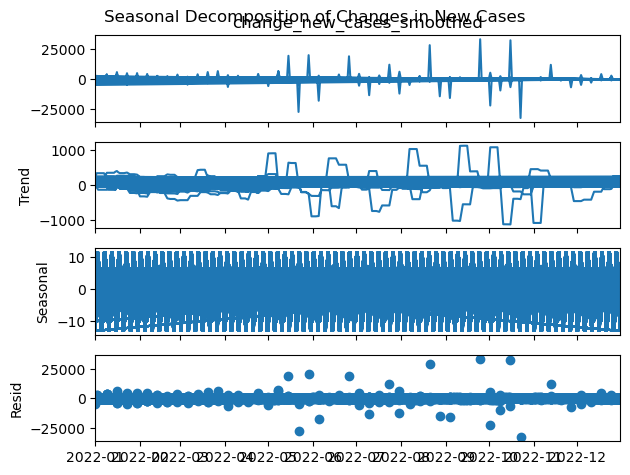

<Figure size 2000x1500 with 0 Axes>

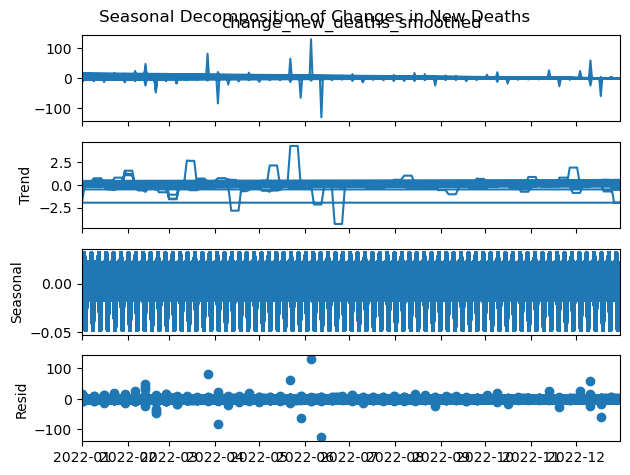

In [11]:
# Plot the decomposed components for cases
plt.figure(figsize=(20, 15))
result_cases.plot()
plt.suptitle('Seasonal Decomposition of Changes in New Cases')
plt.show()

# Plot the decomposed components for deaths
plt.figure(figsize=(20, 15))
result_deaths.plot()
plt.suptitle('Seasonal Decomposition of Changes in New Deaths')
plt.show()

In [12]:
# Time Series Modeling using ARIMA
# Split the data into train and test sets for time series analysis
train_cases, test_cases = train_test_split(data['change_new_cases_smoothed'], test_size=0.2, shuffle=False)
train_deaths, test_deaths = train_test_split(data['change_new_deaths_smoothed'], test_size=0.2, shuffle=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-

                                   SARIMAX Results                                   
Dep. Variable:     change_new_cases_smoothed   No. Observations:                73856
Model:                        ARIMA(5, 1, 0)   Log Likelihood             -538536.188
Date:                       Fri, 23 Aug 2024   AIC                        1077084.375
Time:                               13:15:46   BIC                        1077139.634
Sample:                                    0   HQIC                       1077101.377
                                     - 73856                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8288      0.000  -2306.665      0.000      -0.830      -0.828
ar.L2         -0.6632      0.000  -1435.103      0.000      -0.664      -0.

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Mean Squared Error for Cases (ARIMA): 137665.2919209124


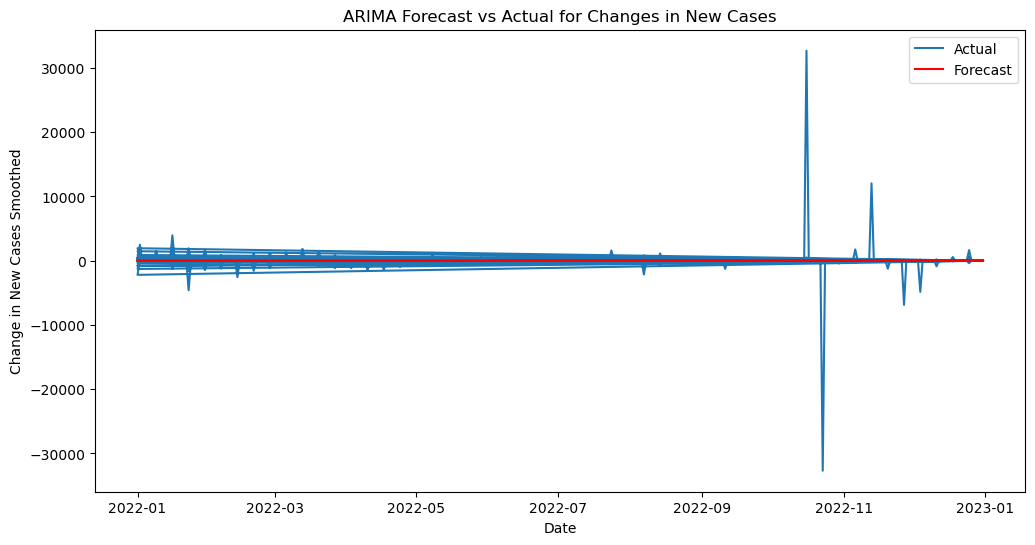

In [13]:
# Fit ARIMA model for cases
model_cases = ARIMA(train_cases, order=(5, 1, 0))
model_cases_fit = model_cases.fit()
print(model_cases_fit.summary())

# Forecast for cases
forecast_cases = model_cases_fit.forecast(steps=len(test_cases))
mse_cases = mean_squared_error(test_cases, forecast_cases)
print(f'Mean Squared Error for Cases (ARIMA): {mse_cases}')


# Plotting the forecasted vs actual values for cases
plt.figure(figsize=(12, 6))
plt.plot(np.array(test_cases.index), np.array(test_cases.values), label='Actual')
plt.plot(np.array(test_cases.index), forecast_cases.values, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Change in New Cases Smoothed')
plt.title('ARIMA Forecast vs Actual for Changes in New Cases')
plt.legend()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-

                                   SARIMAX Results                                    
Dep. Variable:     change_new_deaths_smoothed   No. Observations:                73856
Model:                         ARIMA(5, 1, 0)   Log Likelihood             -121141.577
Date:                        Fri, 23 Aug 2024   AIC                         242295.154
Time:                                13:15:58   BIC                         242350.413
Sample:                                     0   HQIC                        242312.156
                                      - 73856                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8356      0.000  -2633.251      0.000      -0.836      -0.835
ar.L2         -0.6684      0.000  -1678.288      0.000      -0.669 

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Mean Squared Error for Deaths (ARIMA): 0.10197440370450606


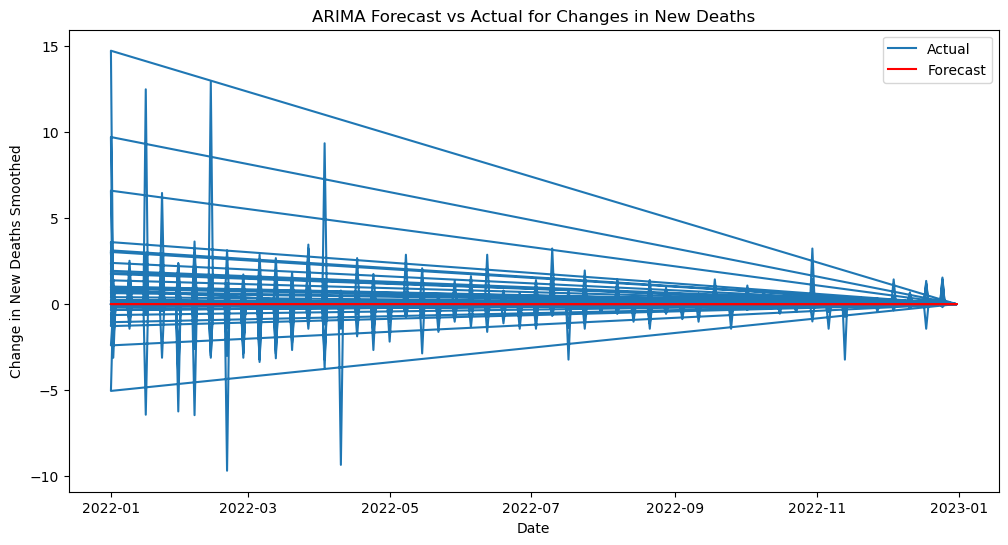

In [14]:
# Fit ARIMA model for deaths
model_deaths = ARIMA(train_deaths, order=(5, 1, 0))
model_deaths_fit = model_deaths.fit()
print(model_deaths_fit.summary())

# Forecast for deaths
forecast_deaths = model_deaths_fit.forecast(steps=len(test_deaths))
mse_deaths = mean_squared_error(test_deaths, forecast_deaths)
print(f'Mean Squared Error for Deaths (ARIMA): {mse_deaths}')


# Plotting the forecasted vs actual values for deaths
plt.figure(figsize=(12, 6))
plt.plot(np.array(test_deaths.index), np.array(test_deaths.values), label='Actual')
plt.plot(np.array(test_deaths.index), forecast_deaths.values, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Change in New Deaths Smoothed')
plt.title('ARIMA Forecast vs Actual for Changes in New Deaths')
plt.legend()
plt.show()